In [1]:
%load_ext autoreload
%autoreload 2

# init and load image - visium tutorial

In [6]:
import os
import numpy as np 
from bokeh.plotting import show, output_notebook
import pandas as pd
import socket
path_to_tissue_tag = 'location of downloaded repo'
os.chdir(path_to_tissue_tag)
import tissue_tag as tt
import matplotlib.pyplot as plt
import scanpy as sc
output_notebook()
host = '5011' # if using jlab/notebook on server 

Loading BokehJS ...

# Step 1 - Load image and define annotation names and colors 

1     2      3             4             5  \
0                                                                  
GTATTCTTACCGTGCT-1  1.0   7.0   21.0   2648.165623   3936.403490   
GCGGTAACCCAAATGA-1  1.0   7.0   23.0   2648.624365   4155.922017   
CTACGTGTTGCCACCA-1  1.0   6.0   24.0   2457.353859   4265.806292   
CTAGATAAACTCCTCG-1  1.0   7.0   25.0   2649.083106   4375.440543   
TCCATTAGTTGGATAG-1  1.0   6.0   26.0   2457.812601   4485.324818   
...                 ...   ...    ...           ...           ...   
CTTGATGACCATCCAG-1  1.0  70.0   98.0  14730.319376  12379.991026   
CTTGCCCACCCACGCA-1  1.0  70.0  100.0  14730.778118  12599.509552   
GGACAACCATGAAGCC-1  1.0  70.0  102.0  14731.236859  12819.028079   
AGGTGCACGTCCACAT-1  1.0  70.0  104.0  14731.695601  13038.546605   
ACCAAGTCATCGGCAG-1  1.0  70.0  106.0  14732.154342  13258.065132   

                    pxl_row_in_fullres  pxl_col_in_fullres      pxl_col  \
0                                                                         
GTATTCTTACCGTGCT-1         1201.223867         1785.576318   892.788159   
GCGGTAACCCAAATGA-1         1201.431955         1885.151243   942.575622   
CTACGTGTTGCCACCA-1         1114.670502         1934.995412   967.497706   
CTAGATAAACTCCTCG-1         1201.640043         1984.726168   992.363084   
TCCATTAGTTGGATAG-1         1114.878590         2034.570337  1017.285168   
...                                ...                 ...          ...   
CTTGATGACCATCCAG-1         6681.761537         5615.638450  2807.819225   
CTTGCCCACCCACGCA-1         6681.969625         5715.213375  2857.606687   
GGACAACCATGAAGCC-1         6682.177713         5814.788300  2907.394150   
AGGTGCACGTCCACAT-1         6682.385801         5914.363225  2957.181612   
ACCAAGTCATCGGCAG-1         6682.593889         6013.938150  3006.969075   

                        pxl_row  
0                                
GTATTCTTACCGTGCT-1   600.611934  
GCGGTAACCCAAATGA-1   600.715978  
CTACGTGTTGCCACCA-1   557.335251  
CTAGATAAACTCCTCG-1   600.820021  
TCCATTAGTTGGATAG-1   557.439295  
...                         ...  
CTTGATGACCATCCAG-1  3340.880769  
CTTGCCCACCCACGCA-1  3340.984813  
GGACAACCATGAAGCC-1  3341.088857  
AGGTGCACGTCCACAT-1  3341.192900  
ACCAAGTCATCGGCAG-1  3341.296944  

[2958 rows x 9 columns]

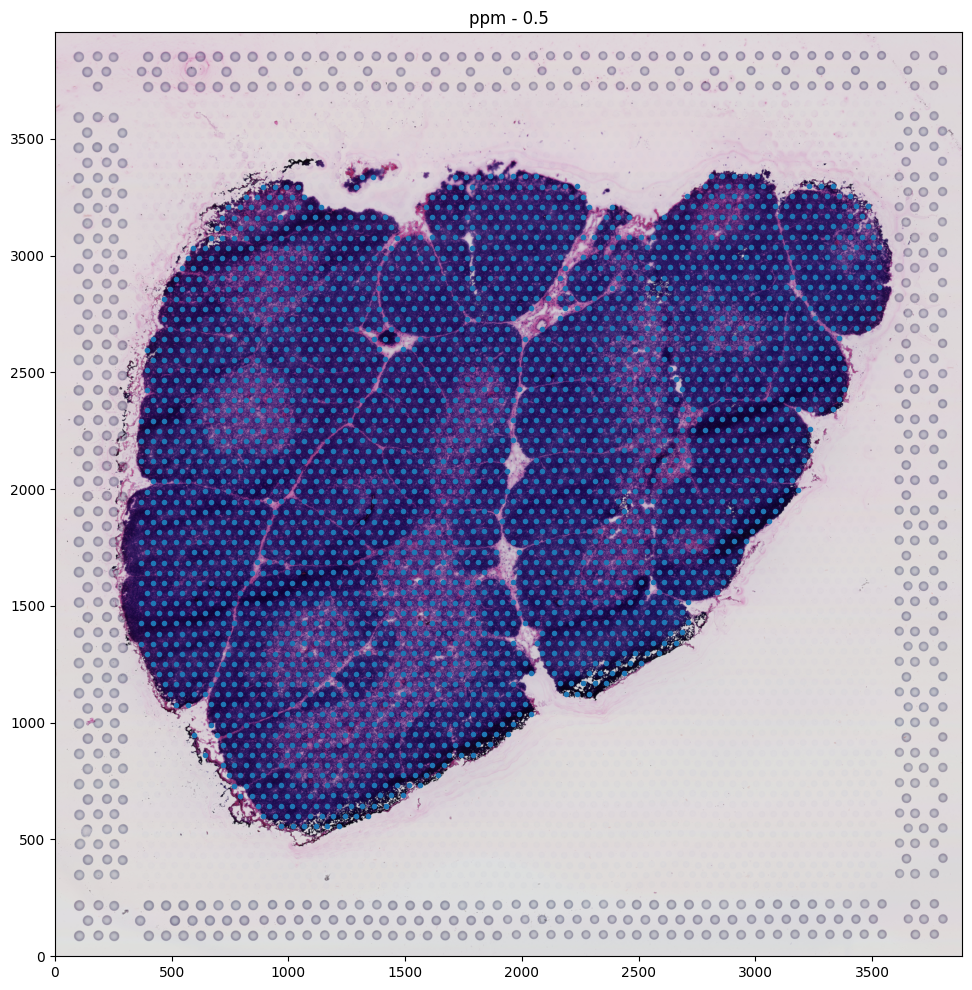

In [45]:
plt.figure(figsize=[12,12])
vis_path = path_to_tissue_tag+'data/tissue_tag_minimal_example_visium/'
im,ppm,df = tt.read_visium(spaceranger_dir_path=vis_path,use_resolution='hires',res_in_ppm=0.5)
df

In [46]:
# define annotations Lv0 
annodict = {
    'unassigned':'yellow',
    'Artifacts':'black',
    'Medulla':'green',
    'Cortex':'cyan',
    'Edge':'brown',
    'HS':'magenta',
    'Vessels':'blue',
    'PVS':'red',
    'Other':'orange',
}

In [47]:
# generate automated labels from markers

# these marker genes would be used to train the classifier in later stages or just to define the annotations if going with the manual option 
gene_markers = { 
    'Medulla' : 'AIRE',
    'Cortex' : 'ARPP21',
    # 'HS' : 'IVL',
}
labels_per_marker = { # how many spots per marker gene
    'Medulla' : 50,
    'Cortex' : 150,
    # 'HS' : 15,
}
r = 50

C:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AIRE
ARPP21


C:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


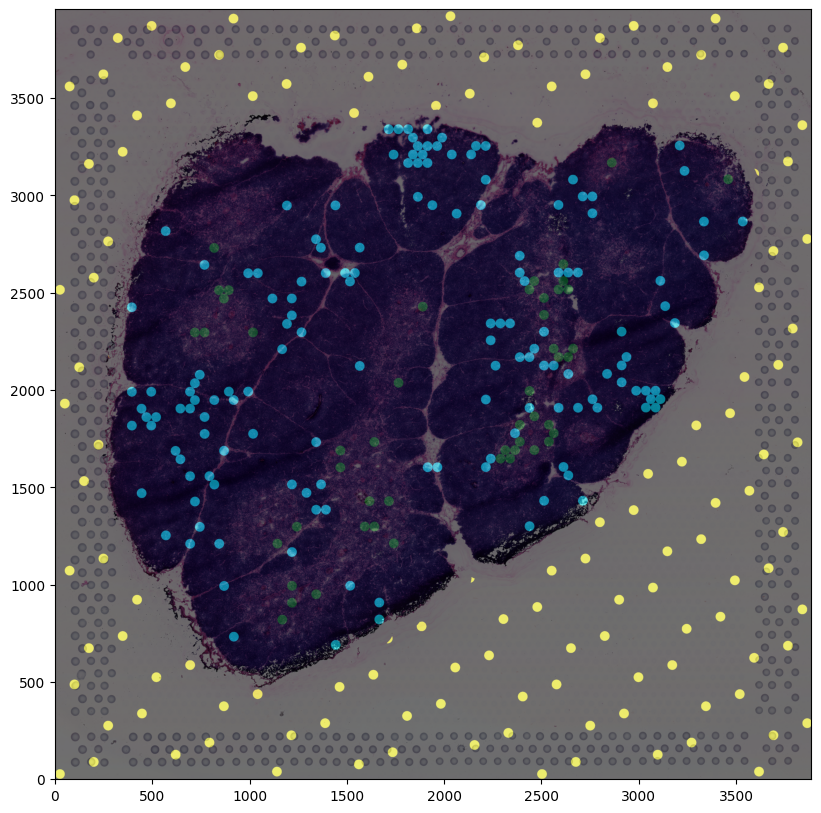

In [48]:
adata = sc.read_visium(vis_path,count_file='raw_feature_bc_matrix.h5')
adata = adata[df.index.intersection(adata.obs.index)]
coordinates = np.array(df.loc[:,['pxl_col','pxl_row']])
training_labels = tt.background_labels(im.shape[:2],coordinates.T,every_x_spots = 100,r=r*ppm) # generate background labels 
training_labels_rgb = tt.rgb_from_labels(training_labels,colors=list(annodict.values()))
training_labels = tt.gene_labels(adata,df,training_labels,gene_markers,annodict,r*ppm,labels_per_marker)
training_labels_rgb = tt.rgb_from_labels(training_labels,colors=list(annodict.values()))
out = tt.overlay_labels(im,training_labels_rgb,alpha=0.5)

# Step 2 - (optional) Predict regions from image

scribble initial annotations or add to predicted annotations

In [50]:
p, render_dict = tt.scribbler(im,annodict)
def app(doc):
    global p
    doc.add_root(p)

import socket
show(app,notebook_url='localhost:8888') # this is on a local machine 
# show(app,notebook_url=f'{socket.gethostname()}:'+host) # this is on server 
print('wait for it.. can take a few tens of seconds on farm...')

wait for it.. can take a few tens of seconds on farm...


## Plot scribble anotations with predicted labels 

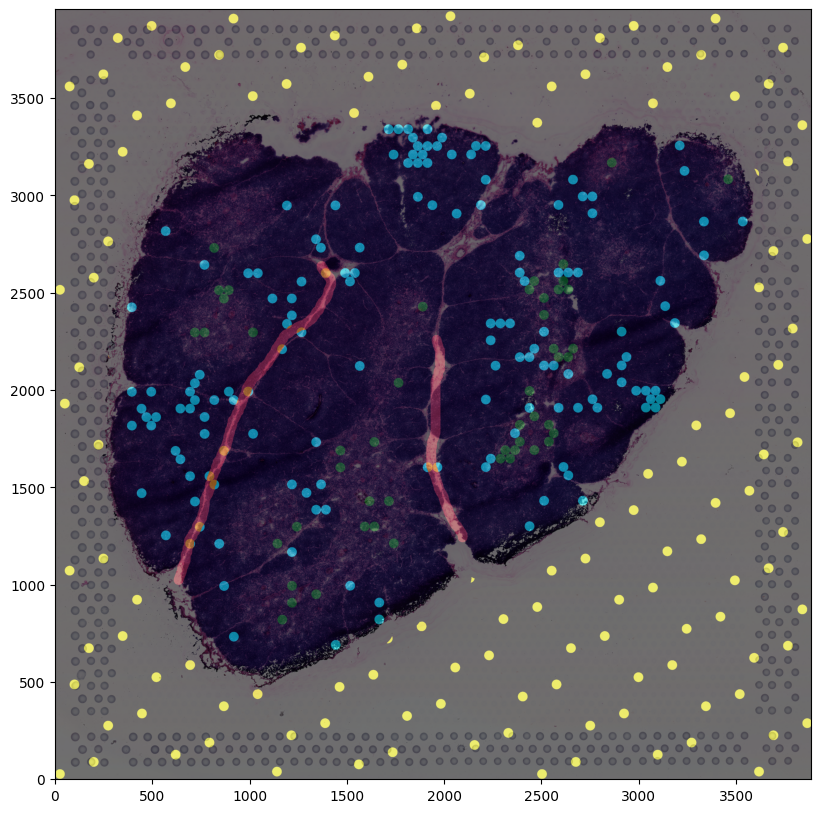

In [51]:
line_width = 100 # microns
training_labels_scrib = tt.scribble_to_labels(im,render_dict,line_width=line_width*ppm)
training_labels = training_labels + training_labels_scrib
training_labels_rgb = tt.rgb_from_labels(training_labels,colors=list(annodict.values()))
out = tt.overlay_labels(im,training_labels_rgb,alpha=0.5)

## run the RF classifier 

CPU times: total: 5min 22s
Wall time: 49.2 s


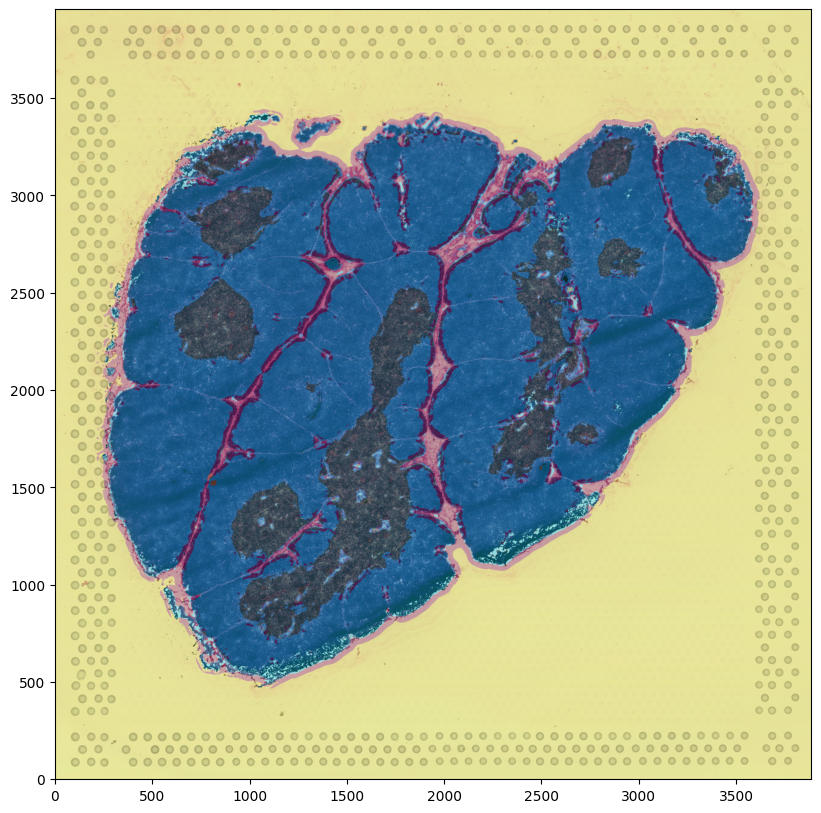

In [52]:
%%time
# this step takes about 30s to 5 min depending on number of training areas and resolution  
result = tt.sk_rf_classifier(im,training_labels)
# plot result 
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.7)

# Step 3 - Manually draw annotations or Correct forest annotations (Step 2)

In [54]:
# at this stage, if you are adding annotations make sure they come after the current ones otherwise it will mess up everything
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5,show=False)
tabs,render_dict = tt.annotator(im,out_img,anno_dict=annodict)
# plotting
def app(doc):
    global tabs
    doc.add_root(tabs)
show(app,notebook_url='localhost:8888') # this is on a local machine 
# show(app,notebook_url=f'{socket.gethostname()}:'+host) # this is on server 
print('wait for it.. can take a few tens of seconds on farm... (double time of the former plot)')

wait for it.. can take a few tens of seconds on farm... (double time of the former plot)


## update annotations 

In [26]:
out_img, result = tt.update_annotator(im,result,anno_dict=annodict,render_dict=render_dict,alpha=0.5)

unassigned
Cortex
Edge
Other


## done? great. not done? return to Step 3 and repeat until happy :) 

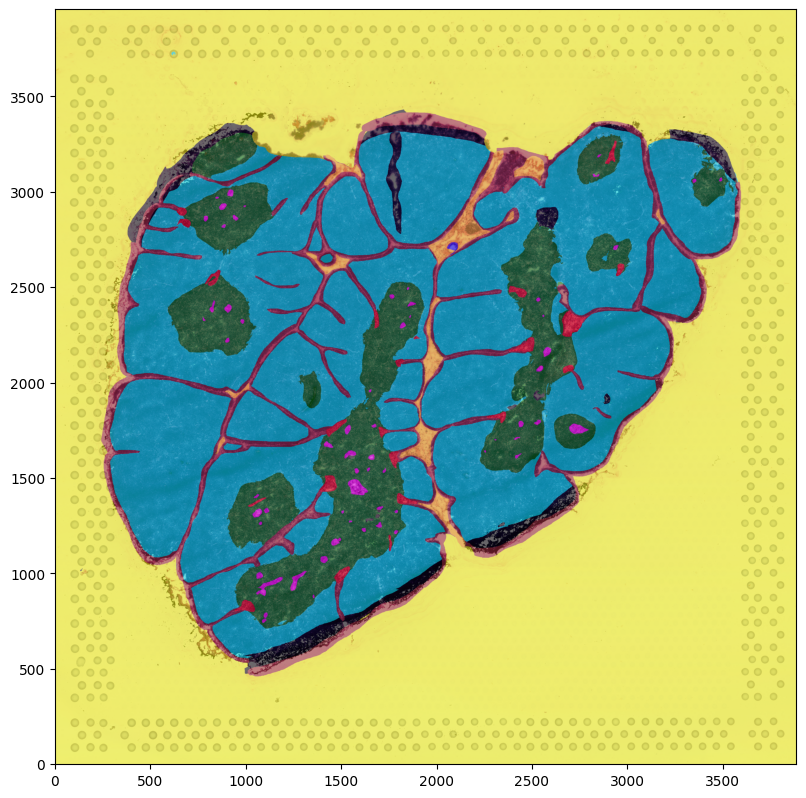

In [28]:
# plot result 
result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)

## save annotation 

In [12]:
isExist = os.path.exists(vis_path+'tissue_annotations')
if not(isExist):
    os.mkdir(vis_path+'/tissue_annotations/')
    
tt.save_annotation(
    folder=vis_path+'/tissue_annotations/',
    label_image=result,
    file_name='annotations',
    anno_names=list(annodict.keys()),
    anno_colors=list(annodict.values()),
    ppm = ppm
)

# Step 4 - move annotations to anndata

## load annotations

In [85]:
spot_diameter = 30 # in microns
df_morph, ppm_morph = tt.load_and_combine_annotations(
    folder=vis_path+'/tissue_annotations/',
    file_names=['annotations'],
    spot_diameter=spot_diameter
)

loaded annotation image - annotations size - (3957, 3886)
loaded annotations
{1: 'unassigned', 2: 'Artifacts', 3: 'Medulla', 4: 'Cortex', 5: 'Edge', 6: 'HS', 7: 'Vessels', 8: 'PVS', 9: 'Other'}
loaded ppm
{'ppm': 0.5}
loaded color annotations
{'unassigned': 'yellow', 'Artifacts': 'black', 'Medulla': 'green', 'Cortex': 'cyan', 'Edge': 'brown', 'HS': 'magenta', 'Vessels': 'blue', 'PVS': 'red', 'Other': 'orange'}
generating grid with spot size - 30, with resolution of - 0.5 ppm
annotations


68640it [00:11, 5747.74it/s]


## migrate annotations to hi res grid sapce 


In [86]:
# remove background spots if you are not interested in it!
df_morph = df_morph.iloc[np.where(df_morph['annotations']!='unassigned')[0],:]
df_morph = df_morph.iloc[np.where(df_morph['annotations']!='Artifacts')[0],:]
df_morph

x            y annotations  annotations_number
index                                                          
2223    253.201553  1672.403076        Edge                   5
2224    253.201553  1687.334595        Edge                   5
2225    253.201553  1702.266113        Edge                   5
2226    253.201553  1717.197754        Edge                   5
2227    253.201553  1732.129272        Edge                   5
...            ...          ...         ...                 ...
65934  3573.248047  2978.948730        Edge                   5
65935  3573.248047  2993.880127      Cortex                   4
65936  3573.248047  3008.811768        Edge                   5
65937  3573.248047  3023.743408        Edge                   5
65938  3573.248047  3038.674805        Edge                   5

[29176 rows x 4 columns]

In [99]:
tt.dist2cluster_fast(df_morph,annotation='annotations',KNN=4) # calculate minimum median distance of each spot to clusters 

calculating distance matrix with cKDTree
Cortex
Edge
HS
Medulla
Other
PVS
Vessels


{'Cortex': array([53.33643289, 49.795783  , 47.72895378, ..., 18.84249561,
        21.85575405, 22.5675716 ]),
 'Edge': array([12.11051283, 11.65075487, 11.65078539, ..., 12.01005274,
        11.60044947, 14.59033413]),
 'HS': array([853.81117112, 851.83253861, 848.93827024, ..., 434.88355388,
        435.55234969, 437.03182728]),
 'Medulla': array([670.48326462, 659.20725555, 647.9434324 , ...,  62.34121745,
         58.07613663,  55.21799831]),
 'Other': array([610.93566188, 611.3082557 , 611.99996668, ..., 426.24315344,
        432.08914057, 438.23733877]),
 'PVS': array([852.10467043, 857.51964972, 863.15892928, ..., 672.3798351 ,
        668.55862842, 664.89888546]),
 'Vessels': array([2090.08182869, 2082.73503258, 2075.46965092, ..., 1504.02747882,
        1507.06325764, 1510.24050142])}

## move annotation and distances to visium spots 

Make sure the coordinate systems are aligned, e.g., axes are not flipped and the resolution is matched.


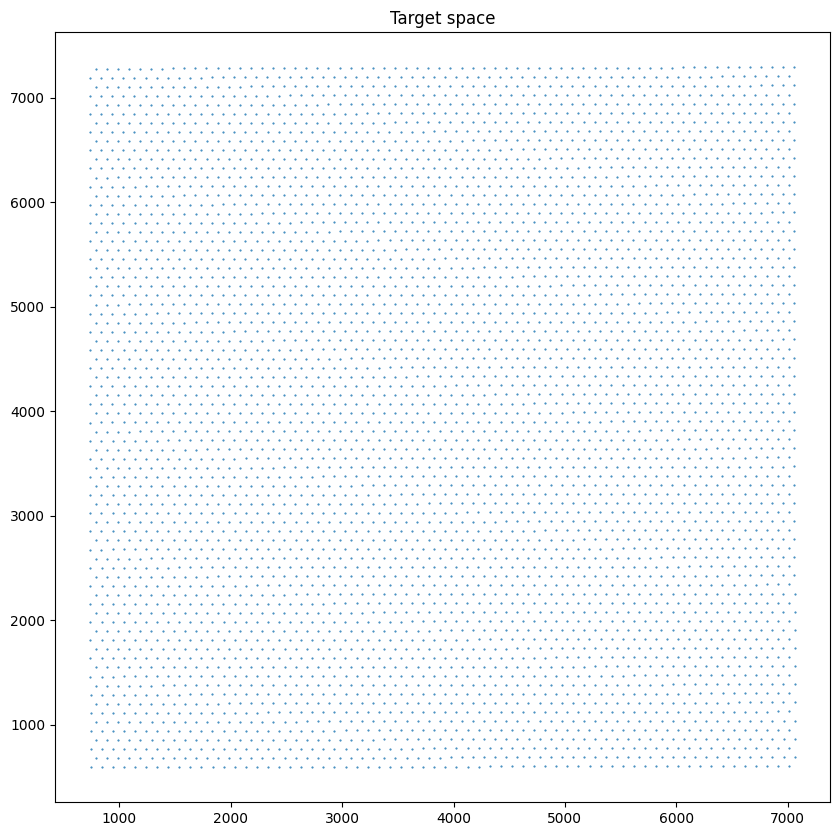

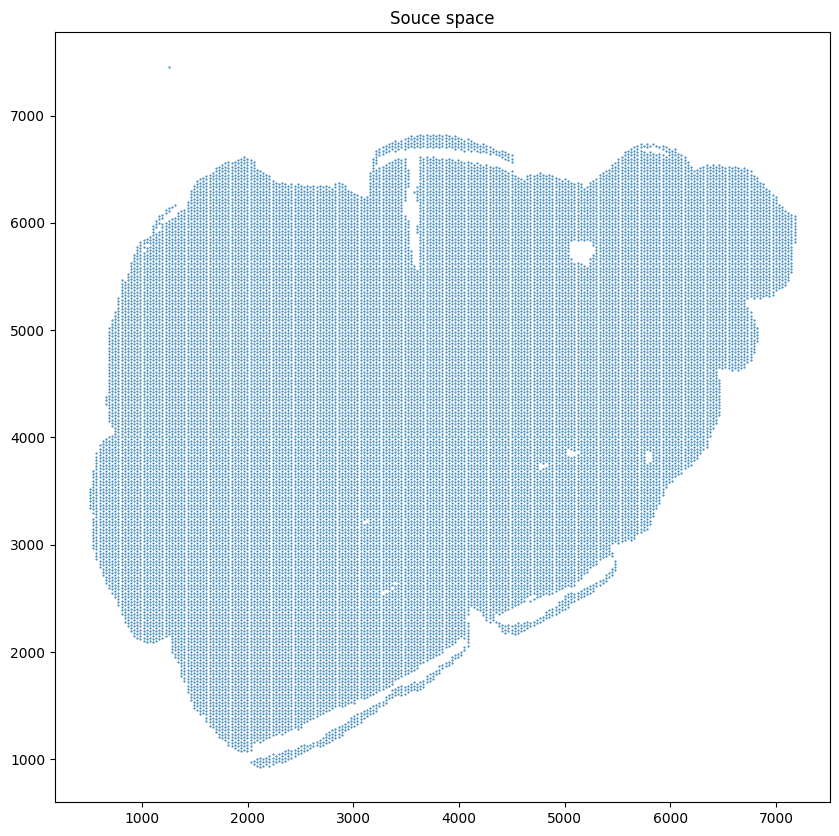

Migrating souce annotation - annotations to target space.
Migrating souce annotation - annotations_number to target space.
Migrating souce annotation - L2_dist_annotations_Cortex to target space.
Migrating souce annotation - L2_dist_annotations_Edge to target space.
Migrating souce annotation - L2_dist_annotations_HS to target space.
Migrating souce annotation - L2_dist_annotations_Medulla to target space.
Migrating souce annotation - L2_dist_annotations_Other to target space.
Migrating souce annotation - L2_dist_annotations_PVS to target space.
Migrating souce annotation - L2_dist_annotations_Vessels to target space.


H:\My Drive\CZI\ThymusSpatialManuscript\codes\tissuetag_test\TissueTag\tissue_tag\tissue_tag.py:1623: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[k][distances==np.inf] = None
H:\My Drive\CZI\ThymusSpatialManuscript\codes\tissuetag_test\TissueTag\tissue_tag\tissue_tag.py:1623: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[k][distances==np.inf] = None
H:\My Drive\CZI\ThymusSpatialManuscript\codes\tissuetag_test\TissueTag\tissue_tag\tissue_tag.py:1623: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

in_tissue     2      3             y             x  \
barcode                                                                  
ACGCCTGACACGCGCT-1        0.0   0.0    0.0   1302.849704   1632.334044   
TACCGATCCAACACTT-1        0.0   1.0    1.0   1494.578951   1741.968295   
ATTAAAGCGGACGAGC-1        0.0   0.0    2.0   1303.308445   1851.852570   
GATAAGGGACGATTAG-1        0.0   1.0    3.0   1495.037692   1961.486822   
GTGCAAATCACCAATA-1        0.0   0.0    4.0   1303.767187   2071.371097   
...                       ...   ...    ...           ...           ...   
GAACGTTTGTATCCAC-1        0.0  77.0  123.0  16076.552779  15123.097526   
ATTGAATTCCCTGTAG-1        0.0  76.0  124.0  15885.282273  15232.981801   
TACCTCACCAATTGTA-1        0.0  77.0  125.0  16077.011520  15342.616052   
AGTCGAATTAGCGTAA-1        0.0  76.0  126.0  15885.741015  15452.500327   
TTGAAGTGCATCTACA-1        0.0  77.0  127.0  16077.470262  15562.134579   

                   annotations  annotations_number  \
barcode                                              
ACGCCTGACACGCGCT-1        None                 NaN   
TACCGATCCAACACTT-1        None                 NaN   
ATTAAAGCGGACGAGC-1        None                 NaN   
GATAAGGGACGATTAG-1        None                 NaN   
GTGCAAATCACCAATA-1        None                 NaN   
...                        ...                 ...   
GAACGTTTGTATCCAC-1        None                 NaN   
ATTGAATTCCCTGTAG-1        None                 NaN   
TACCTCACCAATTGTA-1        None                 NaN   
AGTCGAATTAGCGTAA-1        None                 NaN   
TTGAAGTGCATCTACA-1        None                 NaN   

                    L2_dist_annotations_Cortex  L2_dist_annotations_Edge  \
barcode                                                                    
ACGCCTGACACGCGCT-1                         NaN                       NaN   
TACCGATCCAACACTT-1                         NaN                       NaN   
ATTAAAGCGGACGAGC-1                         NaN                       NaN   
GATAAGGGACGATTAG-1                         NaN                       NaN   
GTGCAAATCACCAATA-1                         NaN                       NaN   
...                                        ...                       ...   
GAACGTTTGTATCCAC-1                         NaN                       NaN   
ATTGAATTCCCTGTAG-1                         NaN                       NaN   
TACCTCACCAATTGTA-1                         NaN                       NaN   
AGTCGAATTAGCGTAA-1                         NaN                       NaN   
TTGAAGTGCATCTACA-1                         NaN                       NaN   

                    L2_dist_annotations_HS  L2_dist_annotations_Medulla  \
barcode                                                                   
ACGCCTGACACGCGCT-1                     NaN                          NaN   
TACCGATCCAACACTT-1                     NaN                          NaN   
ATTAAAGCGGACGAGC-1                     NaN                          NaN   
GATAAGGGACGATTAG-1                     NaN                          NaN   
GTGCAAATCACCAATA-1                     NaN                          NaN   
...                                    ...                          ...   
GAACGTTTGTATCCAC-1                     NaN                          NaN   
ATTGAATTCCCTGTAG-1                     NaN                          NaN   
TACCTCACCAATTGTA-1                     NaN                          NaN   
AGTCGAATTAGCGTAA-1                     NaN                          NaN   
TTGAAGTGCATCTACA-1                     NaN                          NaN   

                    L2_dist_annotations_Other  L2_dist_annotations_PVS  \
barcode                                                                  
ACGCCTGACACGCGCT-1                        NaN                      NaN   
TACCGATCCAACACTT-1                        NaN                      NaN   
ATTAAAGCGGACGAGC-1                        NaN                      NaN   
GATAAGGGACGATTAG-1 

In [101]:
df_visium_spot,ppm_visium = tt.read_visium_table(vis_path)
tt.map_annotations_to_target(df_source=df_morph, df_target=df_visium_spot, ppm_source=ppm_morph,ppm_target=ppm_visium)

In [102]:
import scanpy as sc
os.chdir(vis_path)
adata_vis = sc.read_visium(vis_path,count_file='raw_feature_bc_matrix.h5')
adata_vis.obs.index.rename('barcode',inplace=True)
adata_vis.obs = pd.concat([adata_vis.obs,df_visium_spot.iloc[:,3:]],axis=1)
adata_vis.obs

C:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


in_tissue  array_row  array_col             y  \
barcode                                                             
AAACAACGAATAGTTC-1        0.0        0.0       16.0   1306.519636   
AAACAAGTATCTCCCA-1        1.0       50.0      102.0  10901.239333   
AAACAATCTACTAGCA-1        0.0        3.0       43.0   1887.212274   
AAACACCAATAACTGC-1        1.0       59.0       19.0  12605.700449   
AAACAGAGCGACTCCT-1        0.0       14.0       94.0   4005.408821   
...                       ...        ...        ...           ...   
TTGTTTCACATCCAGG-1        1.0       58.0       42.0  12419.476100   
TTGTTTCATTAGTCTA-1        1.0       60.0       30.0  12799.723404   
TTGTTTCCATACAACT-1        1.0       45.0       27.0   9926.537147   
TTGTTTGTATTACACG-1        0.0       73.0       41.0  15291.744874   
TTGTTTGTGTAAATTC-1        0.0        7.0       51.0   2655.046745   

                               x annotations  annotations_number  \
barcode                                                            
AAACAACGAATAGTTC-1   3388.482256        None                 NaN   
AAACAAGTATCTCCCA-1  12821.528312      Cortex                 4.0   
AAACAATCTACTAGCA-1   6351.607329        None                 NaN   
AAACACCAATAACTGC-1   3710.384357     Medulla                 3.0   
AAACAGAGCGACTCCT-1  11947.954627        None                 NaN   
...                          ...         ...                 ...   
TTGTTTCACATCCAGG-1   6234.972423      Cortex                 4.0   
TTGTTTCATTAGTCTA-1   4917.611241     Medulla                 3.0   
TTGTTTCCATACAACT-1   4590.208626      Cortex                 4.0   
TTGTTTGTATTACACG-1   6123.337985        None                 NaN   
TTGTTTGTGTAAATTC-1   7229.181388        None                 NaN   

                    L2_dist_annotations_Cortex  L2_dist_annotations_Edge  \
barcode                                                                    
AAACAACGAATAGTTC-1                         NaN                       NaN   
AAACAAGTATCTCCCA-1                   11.600477                 94.136081   
AAACAATCTACTAGCA-1                         NaN                       NaN   
AAACACCAATAACTGC-1                  120.864615                183.318070   
AAACAGAGCGACTCCT-1                         NaN                       NaN   
...                                        ...                       ...   
TTGTTTCACATCCAGG-1                   11.600538                 30.799260   
TTGTTTCATTAGTCTA-1                   35.681693                 38.467866   
TTGTTTCCATACAACT-1                   11.600565                 96.631040   
TTGTTTGTATTACACG-1                         NaN                       NaN   
TTGTTTGTGTAAATTC-1                         NaN                       NaN   

                    L2_dist_annotations_HS  L2_dist_annotations_Medulla  \
barcode                                                                   
AAACAACGAATAGTTC-1                     NaN                          NaN   
AAACAAGTATCTCCCA-1              302.843804                   123.369124   
AAACAATCTACTAGCA-1                     NaN                          NaN   
AAACACCAATAACTGC-1               53.916894                    11.600491   
AAACAGAGCGACTCCT-1                     NaN                          NaN   
...                                    ...                          ...   
TTGTTTCACATCCAGG-1              489.536685                   289.459282   
TTGTTTCATTAGTCTA-1              193.888506                    11.600449   
TTGTTTCCATACAACT-1              141.979739                    26.688084   
TTGTTTGTATTACACG-1                     NaN                          NaN   
TTGTTTGTGTAAATTC-1                     NaN                          NaN   

                    L2_dist_annotations_Other  L2_dist_annotations_PVS  \
barcode                                                                  
AAACAACGAATAGTTC-1                        NaN                      NaN   
AAACAAGTATCTCCCA-1                 460.659509     

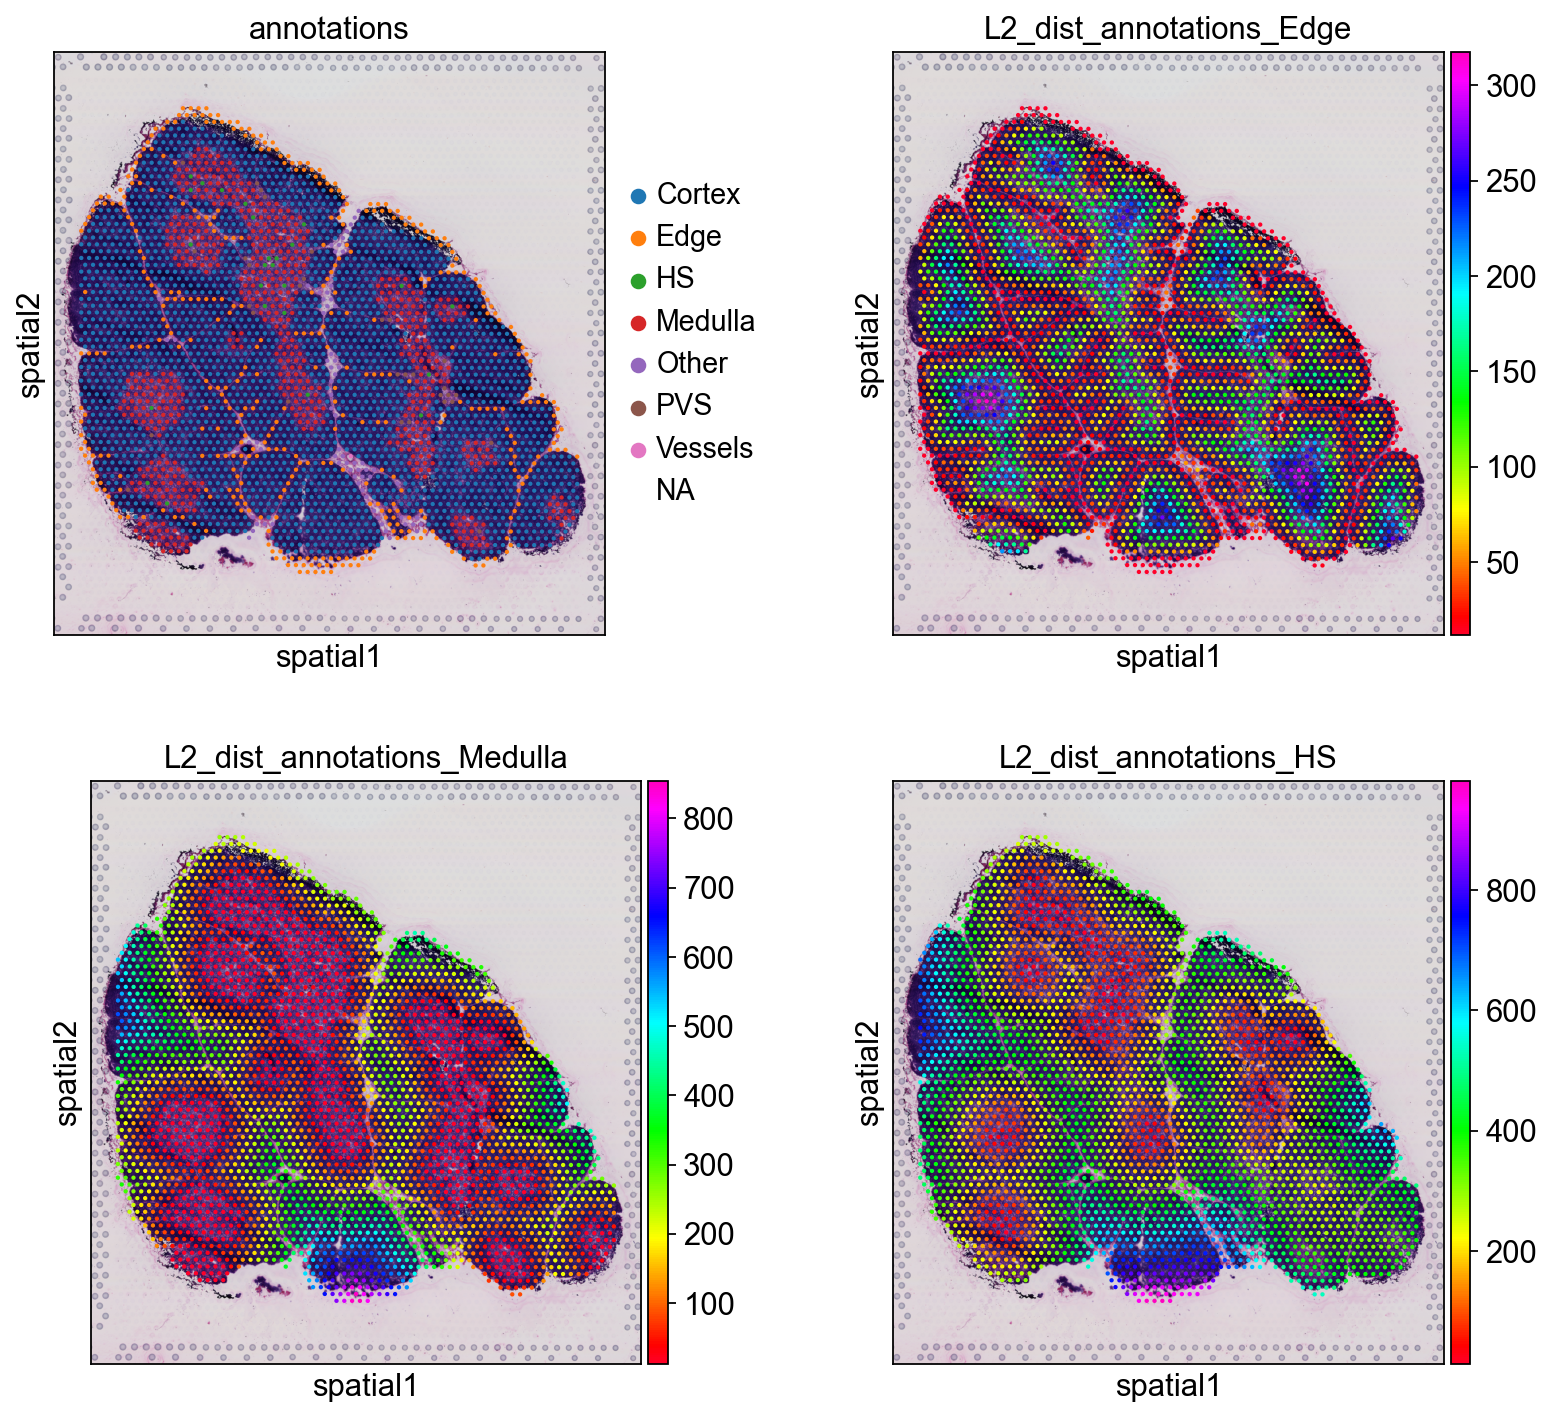

In [104]:
sc.set_figure_params(figsize=[5,5])
sc.pl.spatial(adata_vis,color=['annotations','L2_dist_annotations_Edge','L2_dist_annotations_Medulla','L2_dist_annotations_HS'],cmap='gist_rainbow',ncols=2)